In [121]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, hinge_loss
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from sklearn.model_selection import GridSearchCV
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import ParameterGrid
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
import cv2
import os
import glob
import joblib
import torchvision.utils

In [122]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [123]:
torch.cuda.empty_cache()

In [124]:
# Define paths
train_path = r"C:\Users\ariq dreiki hajjanto\Documents\Gemastik\Dataset\03Filter Gaussian\Training"
test_path = r"C:\Users\ariq dreiki hajjanto\Documents\Gemastik\Dataset\03Filter Gaussian\Testing"

In [125]:
# Define data transforms
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [126]:
# Load datasets
train_dataset = ImageFolder(train_path, transform=data_transform)
test_dataset = ImageFolder(test_path, transform=data_transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=12 , shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=True)

**25088** 

In [127]:
# Load the VGG16 model pre-trained on ImageNet
vgg_model = models.vgg16(pretrained=True)
vgg_model.features = vgg_model.features.to(device)
vgg_model.avgpool = vgg_model.avgpool.to(device)

# Remove the classifier layers and replace with Identity to fetch the 512*7*7=25088 features from the last pool layer
vgg_model.classifier = torch.nn.Identity()

c:\Users\Ariq Dreiki Hajjanto\anaconda3\envs\TA\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ariq Dreiki Hajjanto\anaconda3\envs\TA\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**4096**

In [128]:
# # Load the VGG16 model pre-trained on ImageNet
# vgg_model = models.vgg16(pretrained=True)
# vgg_model = vgg_model.to(device)

# # Remove the final fully connected layers
# vgg_model.classifier = nn.Sequential(*list(vgg_model.classifier.children())[:-3])

In [129]:
# summary(vgg_model, (3, 224, 224))

In [130]:
# vgg_model = models.vgg16(pretrained=True)

# # Function to summarize filter shapes
# def summarize_filter_shapes(model):
#     for layer in model.features:
#         if isinstance(layer, nn.Conv2d):
#             print(f"{layer.__class__.__name__}: {layer.weight.shape}")

# # Summarize filter shapes in VGG16 model
# summarize_filter_shapes(vgg_model)

In [131]:
# # Initialize lists to store convolutional layers and their weights
# conv_layers = []
# conv_weights = []

# # Traverse through the model to extract convolutional layers and their weights
# for module in vgg_model.features.children():
#     if isinstance(module, nn.Conv2d):
#         conv_layers.append(module)
#         conv_weights.append(module.weight)

# # Print total number of convolutional layers found
# print(f"Total convolution layers: {len(conv_layers)}")

**FEATURE MAP**

In [132]:
# # Hook to capture the output of each convolutional layer
# def get_features(name):
#     def hook(model, input, output):
#         features[name] = output.detach()
#     return hook

# # Register hooks for each block
# features = {}
# for idx, layer in enumerate(vgg_model.features):
#     if isinstance(layer, nn.Conv2d):
#         layer.register_forward_hook(get_features(f'conv_{idx}'))

In [133]:
# # Get a batch of images
# dataiter = iter(test_loader)
# images, labels = next(dataiter)  # Use next function to get the batch
# images = images.to(device)

# # Pass the batch through the model
# _ = vgg_model(images)

In [134]:
# # Function to plot feature maps
# def plot_feature_maps(feature_map, layer_name, num_cols=8):
#     num_filters = feature_map.shape[1]
#     num_rows = num_filters // num_cols
#     fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
#     fig.suptitle(f'Feature maps from {layer_name}', fontsize=16)
    
#     for i in range(num_rows):
#         for j in range(num_cols):
#             ax = axes[i, j]
#             ax.imshow(feature_map[0, i*num_cols + j].cpu(), cmap='viridis')
#             ax.axis('off')
    
#     plt.show()

In [135]:
# # Plot the feature maps for each registered layer
# for layer_name, feature_map in features.items():
#     plot_feature_maps(feature_map, layer_name)

In [136]:
# # Define a simple loss function (e.g., Mean Squared Error)
# loss_fn = nn.MSELoss()


In [137]:
# def compute_feature_loss(model, data_loader, loss_fn, device):
#     model.eval()  # Set model to evaluation mode
#     total_loss = 0.0
#     with torch.no_grad():
#         for images, _ in data_loader:
#             images = images.to(device)
#             features = model(images)  # Extract features using VGG-16
#             # Here, we use a dummy target for illustration purposes
#             # In a real scenario, you should replace this with your actual target features or labels
#             target_features = torch.zeros_like(features).to(device)
#             loss = loss_fn(features, target_features)
#             total_loss += loss.item()
#     return total_loss / len(data_loader)

In [138]:
# # Compute loss for the train and test datasets
# train_loss = compute_feature_loss(vgg_model, train_loader, loss_fn, device)
# test_loss = compute_feature_loss(vgg_model, test_loader, loss_fn, device)

# print(f"Train Loss: {train_loss:.4f}")
# print(f"Test Loss: {test_loss:.4f}")

**4096**

In [139]:
# def extract_features(loader, model):
#     features = []
#     labels = []
#     model.eval()  # Set the model to evaluation mode
#     with torch.no_grad():
#         for images, label in loader:
#             images = images.to(device)
#             output = model(images)
#             output = output.view(output.size(0), -1)  # Flatten the outputs
#             features.extend(output.cpu().detach().numpy())
#             labels.extend(label.numpy())
#     return np.array(features), np.array(labels)

In [140]:
# summary(vgg_model, input_size=(3, 224, 224))

**25088**

In [141]:
# Function to extract features
def extract_features(loader, model):
    features = []
    labels = []
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for images, label in loader:
            images = images.to(device)
            output = model(images)
            output = output.view(output.size(0), -1)  # Flatten the outputs
            features.extend(output.cpu().detach().numpy())
            labels.extend(label.numpy())
    return np.array(features), np.array(labels)

In [142]:
# Extract features and labels from training and testing directories
X_train, y_train = extract_features(train_loader, vgg_model)
X_test, y_test = extract_features(test_loader, vgg_model)

In [143]:
print("X_train_pca features shape:", X_train.shape)
print("y_train features shape:", y_train.shape)
print("X_test_pca features shape:", X_test.shape)
print("y_test features shape:", y_test.shape)


X_train_pca features shape: (5708, 25088)
y_train features shape: (5708,)
X_test_pca features shape: (1311, 25088)
y_test features shape: (1311,)


**BAR CHART**

In [144]:
(unique_train, counts_train) = np.unique(y_train, return_counts=True)
(unique_test, counts_test) = np.unique(y_test, return_counts=True)

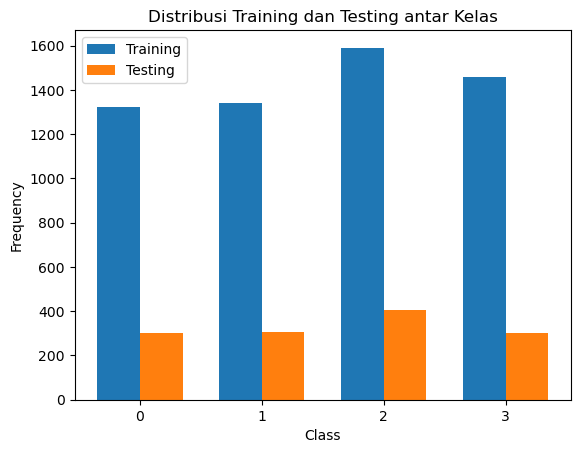

In [145]:
fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(len(unique_train))

bar1 = ax.bar(index, counts_train, bar_width, label='Training')
bar2 = ax.bar(index + bar_width, counts_test, bar_width, label='Testing')

ax.set_xlabel('Class')
ax.set_ylabel('Frequency')
ax.set_title('Distribusi Training dan Testing antar Kelas')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(unique_train)
ax.legend()

plt.show()

**FEATURE PREP**

In [146]:
# Reduce the dimensionality of the features to 1000 using PCA
pca = PCA(n_components=500)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [147]:
# Get explained variance, eigenvalues, and eigenvectors
explained_variance = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_
cumulative_variance = np.cumsum(explained_variance)
components = pca.components_

In [148]:
# Print principal components, eigenvalues, variance %, cumulative variance %, and top contributing features
def print_pca_details(pca, n_components_first, n_components_last):
    explained_variance = pca.explained_variance_ratio_
    eigenvalues = pca.explained_variance_
    cumulative_variance = np.cumsum(explained_variance)
    components = pca.components_

    print(f"{'Component':>10} {'Eigenvalue':>15} {'Variance %':>15} {'Cumulative %':>15} {'Top Contributing Features'}")
    
    # Print first n_components_first components
    for i in range(n_components_first):
        top_features = np.argsort(-np.abs(components[i]))[:5]  # Top 5 contributing features
        top_features_str = ', '.join([f'Feature {j}' for j in top_features])
        print(f"{i+1:>10} {eigenvalues[i]:>15.6f} {explained_variance[i]*100:>15.6f} {cumulative_variance[i]*100:>15.6f} {top_features_str}")

    # Print last n_components_last components
    for i in range(len(eigenvalues) - n_components_last, len(eigenvalues)):
        top_features = np.argsort(-np.abs(components[i]))[:5]  # Top 5 contributing features
        top_features_str = ', '.join([f'Feature {j}' for j in top_features])
        print(f"{i+1:>10} {eigenvalues[i]:>15.6f} {explained_variance[i]*100:>15.6f} {cumulative_variance[i]*100:>15.6f} {top_features_str}")

# Print details for the first 5 and the last 5 components
print_pca_details(pca, 5, 5)

 Component      Eigenvalue      Variance %    Cumulative % Top Contributing Features
         1      836.323608        8.730377        8.730377 Feature 22180, Feature 22187, Feature 5325, Feature 10473, Feature 22178
         2      471.481995        4.921797       13.652174 Feature 22795, Feature 22794, Feature 843, Feature 11184, Feature 1592
         3      315.724426        3.295845       16.948019 Feature 13633, Feature 12799, Feature 21227, Feature 19609, Feature 19629
         4      251.711151        2.627611       19.575630 Feature 16922, Feature 11191, Feature 16915, Feature 11190, Feature 11194
         5      186.823593        1.950250       21.525881 Feature 16923, Feature 16915, Feature 21942, Feature 16922, Feature 16921
       496        2.584786        0.026983       75.439227 Feature 24279, Feature 18539, Feature 24049, Feature 7767, Feature 8450
       497        2.576611        0.026897       75.466126 Feature 8851, Feature 20954, Feature 8558, Feature 11677, Featur

In [149]:
# # Save extracted features as CSV
# save_features_to_csv(X_train_pca, y_train, "X_train_features75_25(500).csv")
# save_features_to_csv(X_test_pca, y_test, "X_test_features75_25(500).csv")

In [150]:
print("X_train_pca features shape:", X_train_pca.shape)
print("y_train features shape:", y_train.shape)
print("X_test_pca features shape:", X_test_pca.shape)
print("y_test features shape:", y_test.shape)


X_train_pca features shape: (5708, 500)
y_train features shape: (5708,)
X_test_pca features shape: (1311, 500)
y_test features shape: (1311,)


In [151]:
print ('array',X_train_pca)

array [[-10.905111   -12.323516   -10.513702   ...   0.27966568  -2.467205
    2.632719  ]
 [-35.28553    -16.675095     3.4434617  ...  -1.3542924    0.62071335
    1.1122295 ]
 [ 26.599644   -20.505283    -8.686203   ...   0.3027804   -1.0524768
    3.3441832 ]
 ...
 [-16.732544   -27.227448    -9.232772   ...  -1.0087962    3.2320602
   -0.71008146]
 [-19.411978   -17.35558     -8.808305   ...   2.172015    -0.14531459
   -1.072245  ]
 [-28.366743    10.356462    -1.6661077  ...  -1.5746776    0.907715
   -2.8645582 ]]


In [152]:
print("Unique labels in y_train:", np.unique(y_train))
print("Unique labels in y_test:", np.unique(y_test))


Unique labels in y_train: [0 1 2 3]
Unique labels in y_test: [0 1 2 3]


In [153]:
# Create dataframes for training and testing labels
df_train_labels = pd.DataFrame({'label': y_train})
df_test_labels = pd.DataFrame({'label': y_test})

# Save dataframes to CSV files
df_train_labels.to_csv('train_labels.csv', index=False)
df_test_labels.to_csv('test_labels.csv', index=False)

In [154]:
df = pd.read_csv(r"C:\Users\Ariq Dreiki Hajjanto\Documents\Tugas Akhir\Dataset\Machine Learning\CNN\X_test_features75_25(500).csv")
df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_491,feature_492,feature_493,feature_494,feature_495,feature_496,feature_497,feature_498,feature_499,label
0,10.511559,-5.431477,6.285061,12.177332,6.286790,11.766777,-5.671471,-1.533015,-2.033644,-10.141530,...,0.288168,-0.065803,0.019061,-0.033767,0.198118,-0.239722,0.635192,0.163184,-0.107296,0.0
1,14.325336,-4.527335,2.205653,1.509537,-1.528994,6.603287,0.896018,1.126131,4.172558,-1.285184,...,0.247807,-0.192542,0.032904,0.300811,0.299693,-0.655906,-0.319232,-0.136365,-0.040399,0.0
2,6.915482,-5.384059,3.740627,7.247207,-8.938292,0.493883,-5.342059,-7.366040,4.964869,-2.729272,...,0.042205,-0.240618,-0.335752,0.176880,0.124362,-0.118099,-0.201583,0.074290,-0.041683,0.0
3,17.077791,-2.343871,-6.996035,-3.769801,-2.010015,-1.759477,3.115609,3.394544,0.976481,-0.019749,...,0.169219,-0.349689,0.045585,0.147997,0.075410,0.086490,0.172611,-0.163481,-0.184597,0.0
4,18.601532,-6.679881,0.975107,-1.382781,-6.336427,-1.704565,1.523601,-0.596003,0.364117,0.432563,...,0.032785,0.124413,0.076599,-0.171349,0.211474,-0.109480,0.055179,0.019970,0.174918,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,-9.793530,-0.819795,-7.981409,-0.687741,-0.191810,-1.271927,-4.207448,-2.623264,0.614717,-0.860412,...,-0.219102,-0.102668,-0.094349,0.054339,0.073950,-0.227290,0.302033,-0.200304,0.185782,2.0
1254,-9.710343,6.544523,-2.288808,-4.850384,-0.831809,-0.486767,3.153833,0.138145,-0.352537,-2.139787,...,0.242520,0.088295,0.091309,-0.022090,-0.123255,-0.056613,0.104610,-0.110341,0.157517,2.0
1255,-8.319013,11.296519,-1.125949,-4.851100,-0.283304,3.852579,-0.240424,1.610330,-1.090016,-3.180235,...,0.029720,0.177862,0.016209,0.218248,0.115045,-0.086797,0.078046,-0.087551,0.138562,2.0
1256,-9.280158,4.285591,3.838337,-5.547789,-3.657363,-1.118607,1.092592,0.671854,-1.718644,-3.027125,...,-0.045330,-0.035475,0.005771,-0.019528,-0.273243,-0.172468,0.180011,0.148098,-0.078330,2.0


In [155]:
df.isnull().sum()

feature_0      0
feature_1      0
feature_2      0
feature_3      0
feature_4      0
              ..
feature_496    0
feature_497    0
feature_498    0
feature_499    0
label          0
Length: 501, dtype: int64

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Columns: 501 entries, feature_0 to label
dtypes: float64(501)
memory usage: 4.8 MB


In [157]:
df.describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_491,feature_492,feature_493,feature_494,feature_495,feature_496,feature_497,feature_498,feature_499,label
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,...,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,-0.354293,-0.201611,0.391080,-0.123702,0.255030,-0.009533,-0.031883,-0.198762,0.027395,0.231669,...,-0.003217,-0.002908,-0.002796,0.002071,0.006562,0.011800,-0.006461,0.024738,-0.009061,1.027027
std,8.558413,6.187779,5.938289,5.037132,4.219846,3.657507,3.619976,3.505539,3.242868,2.939893,...,0.212825,0.209742,0.206520,0.207516,0.206462,0.199747,0.201119,0.208374,0.206424,0.819939
min,-13.372332,-15.777857,-14.821510,-16.448332,-11.811508,-10.347757,-11.401688,-11.350851,-10.572464,-10.396530,...,-0.811534,-0.753009,-0.740332,-0.735174,-0.639603,-0.689934,-0.839210,-0.828968,-0.764289,0.000000
25%,-7.670744,-4.542188,-4.098484,-3.618386,-2.613059,-2.431137,-2.471014,-2.458703,-2.080444,-1.758559,...,-0.144163,-0.140068,-0.141363,-0.135100,-0.123793,-0.108444,-0.136279,-0.111358,-0.140336,0.000000
50%,-3.362357,-0.988390,0.305843,-0.043435,0.263579,0.002395,0.030986,-0.184041,-0.109030,0.063562,...,-0.005245,-0.001323,0.001628,0.011913,0.006607,0.014750,-0.004884,0.016912,-0.012209,1.000000
75%,7.335514,3.825564,5.250748,3.421775,2.816004,2.483072,2.452842,2.105461,2.024122,2.175377,...,0.140572,0.132297,0.141815,0.137180,0.136886,0.140164,0.128270,0.159012,0.125657,2.000000
max,20.022760,19.440140,15.243138,13.871941,14.180123,11.766777,11.597020,11.267826,10.102296,9.711976,...,0.784893,1.012737,0.941463,0.741688,0.602027,0.689523,0.879369,0.719724,0.884364,2.000000


In [158]:
df.nunique()

feature_0      1250
feature_1      1250
feature_2      1250
feature_3      1250
feature_4      1250
               ... 
feature_496    1250
feature_497    1250
feature_498    1250
feature_499    1250
label             3
Length: 501, dtype: int64

***HYPERPARAMETER TUNING***

In [159]:
# Define the parameters grid for each kernel
param_grids = {
    'rbf': {'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1]},
    'sigmoid': {'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1], 'coef0': [0.0, 0.5, 1.0]},
    'poly': {'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4, 5, 6], 'coef0': [0.0, 0.5, 1.0, 1.5]}
}

In [160]:
# Initialize best parameters and best accuracy for each kernel
best_params = {}
best_accuracy = {}

In [161]:
# Initialize a dictionary to hold all results
results = {
    'rbf': [],
    'sigmoid': [],
    'poly': []
}

In [162]:
# Loop through each kernel
for kernel, param_grid in param_grids.items():
    # Initialize best accuracy for current kernel
    best_accuracy[kernel] = 0
    
    # Loop through each parameter combination for current kernel
    for params in ParameterGrid(param_grid):
        # Initialize SVM classifier with current parameters
        svm_classifier = SVC(kernel=kernel, **params)
        
        # Train SVM classifier on training data
        svm_classifier.fit(X_train_pca, y_train)
        
        # Make predictions on test data
        y_pred = svm_classifier.predict(X_test_pca)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        # Store results in the list
        result = dict(params, **{'Accuracy': accuracy})
        results[kernel].append(result)

        # Print accuracy for the current parameter combination
        print(f"Kernel: {kernel}, Parameters: {params}, Accuracy: {accuracy}")
        
        # Check if current accuracy is better than previous best accuracy for current kernel
        if accuracy > best_accuracy[kernel]:
            # Update best accuracy and parameters for current kernel
            best_accuracy[kernel] = accuracy
            best_params[kernel] = params

Kernel: rbf, Parameters: {'C': 0.1, 'gamma': 0.001}, Accuracy: 0.30892448512585813
Kernel: rbf, Parameters: {'C': 0.1, 'gamma': 0.01}, Accuracy: 0.30892448512585813
Kernel: rbf, Parameters: {'C': 0.1, 'gamma': 0.1}, Accuracy: 0.30892448512585813
Kernel: rbf, Parameters: {'C': 0.1, 'gamma': 1}, Accuracy: 0.30892448512585813
Kernel: rbf, Parameters: {'C': 1, 'gamma': 0.001}, Accuracy: 0.9016018306636155
Kernel: rbf, Parameters: {'C': 1, 'gamma': 0.01}, Accuracy: 0.4744469870327994
Kernel: rbf, Parameters: {'C': 1, 'gamma': 0.1}, Accuracy: 0.39359267734553777
Kernel: rbf, Parameters: {'C': 1, 'gamma': 1}, Accuracy: 0.3897787948131198
Kernel: rbf, Parameters: {'C': 10, 'gamma': 0.001}, Accuracy: 0.9092295957284515
Kernel: rbf, Parameters: {'C': 10, 'gamma': 0.01}, Accuracy: 0.4919908466819222
Kernel: rbf, Parameters: {'C': 10, 'gamma': 0.1}, Accuracy: 0.39359267734553777
Kernel: rbf, Parameters: {'C': 10, 'gamma': 1}, Accuracy: 0.3897787948131198
Kernel: rbf, Parameters: {'C': 100, 'gamma'

In [163]:
print("Best parameters for each kernel:")
for kernel, params in best_params.items():
    print(f"{kernel}: {params} - Accuracy: ", end="")
    if best_accuracy[kernel] == max(best_accuracy.values()):
        print(f"\033[1m{best_accuracy[kernel]}\033[0m (Best)")
    else:
        print(best_accuracy[kernel])

Best parameters for each kernel:
rbf: {'C': 10, 'gamma': 0.001} - Accuracy: 0.9092295957284515
sigmoid: {'C': 0.1, 'coef0': 0.0, 'gamma': 0.001} - Accuracy: 0.631578947368421
poly: {'C': 10, 'coef0': 0.5, 'degree': 4} - Accuracy: 0.9801678108314263 (Best)


**SAVE To CSV**

In [164]:
for kernel, data in results.items():
    # Convert list of dictionaries to DataFrame
    df = pd.DataFrame(data)
    # Save DataFrame to CSV
    df.to_csv(f"{kernel}_kernel_results (25088_500).csv", index=False)

print("Results have been saved to CSV files.")

Results have been saved to CSV files.


***SVM CLASSIFIER***

In [165]:
# Train the SVM classifier with the best hyperparameters
best_svm_classifier = SVC(kernel='poly',C= 10.0, coef0= 0.0, degree= 3)#poly: {'C': 1, 'coef0': 1.0, 'degree': 4}
best_svm_classifier.fit(X_train_pca, y_train)

SVC(C=10.0, kernel='poly')

In [166]:
# # Save VGG16 feature extractor
# torch.save(vgg_model.state_dict(), 'vgg16_feature_extractor.pth')

# # Save PCA model
# joblib.dump(pca, 'pca_model.pkl')

# # Save trained SVM classifier
# joblib.dump(best_svm_classifier, 'svm_classifier.pkl')

In [167]:
# Make predictions on the test set
y_pred = best_svm_classifier.predict(X_test_pca)

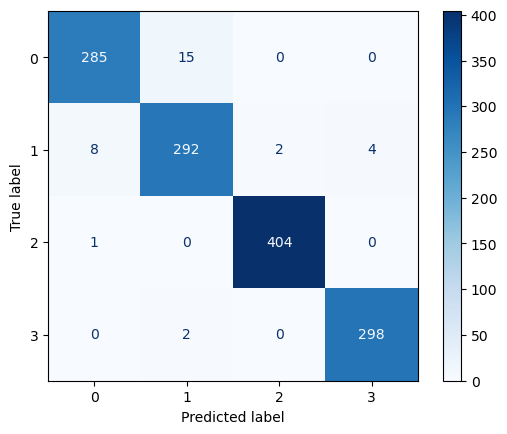

In [168]:
cm = confusion_matrix(y_test, y_pred, labels=best_svm_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=best_svm_classifier.classes_)
disp.plot(cmap='Blues')
plt.show()

In [169]:
# Define a dictionary to map numerical labels to class labels
numerical_to_class = {0: 'glioma', 1: 'meningioma', 2: 'notumor',3:'pituitary'}

# Convert numerical labels in y_test and y_pred to class labels
y_test_class = np.array([numerical_to_class[label] for label in y_test])
y_pred_class = np.array([numerical_to_class[label] for label in y_pred])

# Evaluate the classifier
print("Classification Report:")
print(classification_report(y_test_class, y_pred_class))
print("Accuracy:", accuracy_score(y_test_class, y_pred_class))

Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.95      0.96       300
  meningioma       0.94      0.95      0.95       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.98      0.98      0.98      1311

Accuracy: 0.9755911517925248


In [170]:
# Calculate decision function scores
decision_function = best_svm_classifier.decision_function(X_test_pca)

# Calculate hinge loss
loss = hinge_loss(y_test, decision_function)
print("Hinge Loss on the test set:", loss)

Hinge Loss on the test set: 0.04956287367925649


In [171]:
print("Number of iterations for each class:")
for i, cls in enumerate(best_svm_classifier.classes_):
    print(f"{numerical_to_class[cls]}: {best_svm_classifier.n_iter_[i]}")

Number of iterations for each class:
glioma: 3886
meningioma: 1720
notumor: 1756
pituitary: 2387


In [172]:
def specificity_score(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    specificity = {}
    for i, label in enumerate(labels):
        true_negatives = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        false_positives = cm[:, i].sum() - cm[i, i]
        specificity[label] = true_negatives / (true_negatives + false_positives)
    return specificity

In [173]:
# Get the class labels
class_labels = list(numerical_to_class.values())

# Calculate and print Specificity for each class
specificity = specificity_score(y_test_class, y_pred_class, class_labels)
print("Specificity:")
for label in class_labels:
    print(f"{label}: {specificity[label]:.4f}")

Specificity:
glioma: 0.9911
meningioma: 0.9831
notumor: 0.9978
pituitary: 0.9960


In [174]:
# Define image size
SIZE = 224
train_images = []
train_labels = []

test_images = []
test_labels = []

In [175]:
for directory_path in glob.glob(os.path.join(train_path, "*")):
    label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        train_images.append(img)  # Append image array
        train_labels.append(label)

for directory_path in glob.glob(os.path.join(test_path, "*")):
    label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        test_images.append(img)  # Append image array
        test_labels.append(label)

In [176]:
label_encoder = LabelEncoder()
# Fit label encoder and return encoded labels
y_train_encoded = label_encoder.fit_transform(train_labels)
y_test_encoded = label_encoder.transform(test_labels)

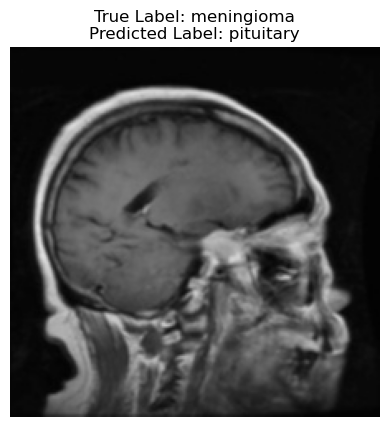

In [193]:

# Choose a random index for selecting an image
random_index = np.random.choice(len(test_images))

# Display the selected image with true and predicted labels
image = test_images[random_index]
true_label = test_labels[random_index]
predicted_label = label_encoder.inverse_transform([y_pred[random_index]])[0]

plt.imshow(image)
plt.axis('off')
plt.title(f'True Label: {true_label}\nPredicted Label: {predicted_label}')
plt.show()

In [178]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
best_svm_classifier.fit(X_train_pca, y_train)

x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = best_svm_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

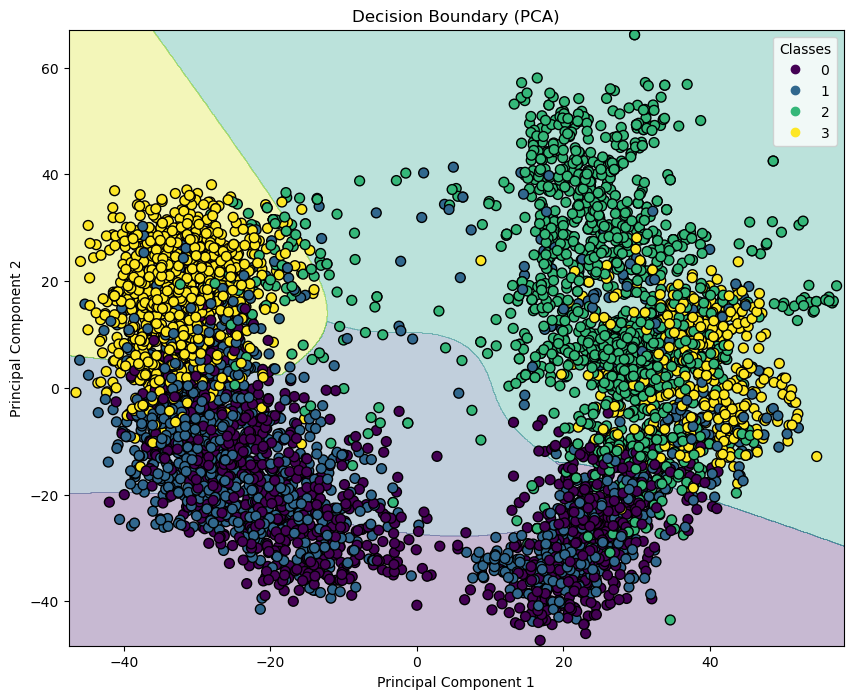

In [179]:
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
scatter= plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', s=50, edgecolors='k')
handles, labels = scatter.legend_elements()
plt.legend(handles, labels, loc="upper right", title="Classes")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundary (PCA)')
plt.show()

In [180]:
# Plot decision boundary using test data
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = best_svm_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

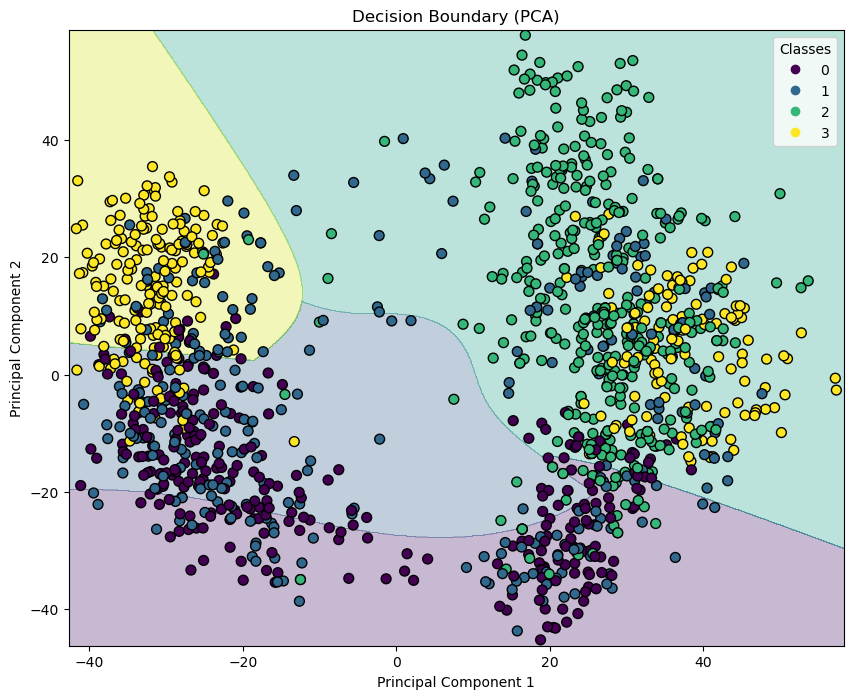

In [181]:
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
scatter1= plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='viridis', s=50, edgecolors='k')
# Add legend
handles1, labels1 = scatter1.legend_elements()
plt.legend(handles1, labels1, loc="upper right", title="Classes")

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundary (PCA)')
plt.show()

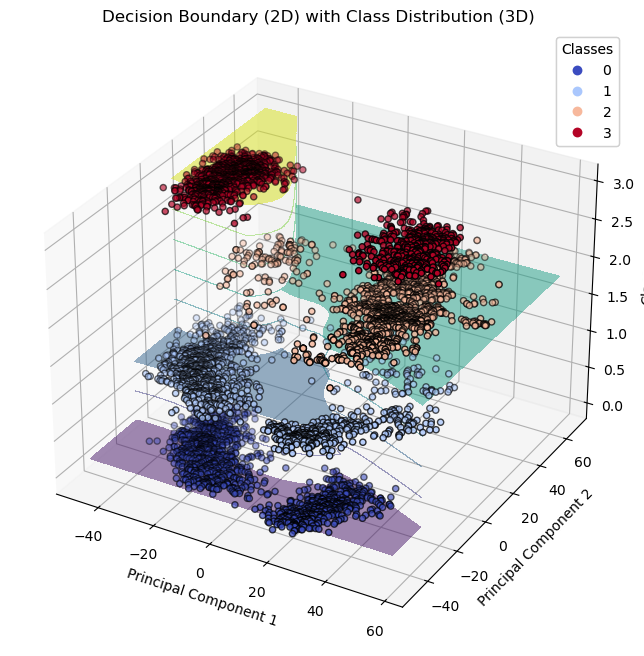

In [182]:
# Plot the decision boundary in 2D with class distribution in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot decision boundary
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z = best_svm_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, alpha=0.5)
# Plot class distribution in 3D
scatter = ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], y_train, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Class')
ax.set_title('Decision Boundary (2D) with Class Distribution (3D)')

# Add legend for class distribution
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)

plt.show()

In [183]:
# # Perform the nonlinear transformation
# X_train_transformed = np.zeros((X_train_pca.shape[0], 3))
# X_train_transformed[:, 0] = X_train_pca[:, 0] ** 2
# X_train_transformed[:, 1] = X_train_pca[:, 1] - np.sqrt(X_train_pca[:, 0] * X_train_pca[:, 1])
# X_train_transformed[:, 2] = X_train_pca[:, 1] ** 2

In [184]:
# # Check for NaN values in the transformed features
# nan_indices = np.isnan(X_train_transformed).any(axis=1)

# # Replace NaN values with the mean of the column
# X_train_transformed[nan_indices] = np.nanmean(X_train_transformed, axis=0)

# # Train the SVM classifier on the transformed data
# best_svm_classifier.fit(X_train_transformed, y_train)

In [185]:
# # Define the range of the meshgrid in the transformed space
# x_min, x_max = X_train_transformed[:, 0].min() - 1, X_train_transformed[:, 0].max() + 1
# y_min, y_max = X_train_transformed[:, 1].min() - 1, X_train_transformed[:, 1].max() + 1
# z_min, z_max = X_train_transformed[:, 2].min() - 1, X_train_transformed[:, 2].max() + 1

# # Define the step size for each dimension
# step_size = 0.5

# # Create a meshgrid in the transformed space with the specified step size
# xx, yy, zz = np.meshgrid(np.arange(x_min, x_max, step_size),
#                          np.arange(y_min, y_max, step_size),
#                          np.arange(z_min, z_max, step_size))

# # Predict the class labels for each point on the meshgrid
# meshgrid_points = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
# Z = best_svm_classifier.predict(meshgrid_points)
# Z = Z.reshape(xx.shape)

In [186]:
# # Plot decision boundary and class distribution in 3D
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X_train_transformed[:, 0], X_train_transformed[:, 1], X_train_transformed[:, 2], c=y_train, cmap='viridis', s=50, edgecolors='k')
# Z_2d = Z[:,:,0]

# # Plot the decision boundary
# ax.contourf(xx[:,:,0], yy[:,:,0], Z_2d, alpha=0.3, cmap='viridis')

# # Set labels and title
# ax.set_xlabel('Transformed Feature 1')
# ax.set_ylabel('Transformed Feature 2')
# ax.set_zlabel('Transformed Feature 3')
# ax.set_title('Decision Boundary in Transformed 3D Space')

# # Add legend for class distribution
# handles, labels = scatter.legend_elements()
# ax.legend(handles, labels, loc="upper right", title="Classes")

# plt.show()